# Held et al. two-layer RCMIP

Here we perform the Held et al. two-layer model runs for RCMIP. This notebook shows how the OpenSCM library should 'feel' to the end user. We're not at that point yet and will need a major re-write to get it workable, but this at least shows where we're going.

## Imports

In [1]:
import datetime as dt
import json
import os.path

import numpy as np
import pandas as pd
import pyam
import tqdm.notebook
from scmdata import df_append, ScmDataFrame

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

<IPython.core.display.Javascript object>

In [2]:
F2X_CO2 = 3.74  # W / m^2

## Models

In [3]:
class HeldTwoLayerModel():
    """
    Quick implementation of Held two layer model (Held et al. 2010)
    including state dependent feedback factor.
    
    Based on:
    
    C dT/dt = F + (\\lambda_0 + b T) T - \\epsilon \\eta (T - T_D)
    
    C_D dT_D/dt = \\eta (T - T_D)
    
    where C is heat capacity of upper ocean (J K^-1 m^-2), C_D is heat capacity
    of deep ocean, T is temperature change of upper ocean (K), T_D is 
    temperature change of deep ocean, \\lambda_0 is initial
    feedback factor (W m^-2 K^-1), b is state dependent feedback term (W m^-2 K^-2),
    \\epsilon is efficacy factor for ocean heat uptake (dimensionless)
    and \\eta is heat transport efficiency (W m^-2 K^-1).
    
    Inputs should all be on an annual timestep (no checks are done for
    this...).
    
    If you're used to the energy balance model, 
    
    F = \\lambda T + dH/dt
    
    then be careful, the sign of \\lambda follows the opposite convention
    here i.e. \\lambda is negative.
    """

    name = "held_two_layer_model"

    C = (
        1000  # density of water (kg m^-3)
        * 4181  # heat capacity of water (J K^-1 kg^-1)
        * 50  # depth of upper layer (m)
    )
    C_D = (
        1000  # density of water (kg m^-3)
        * 4181  # heat capacity of water (J K^-1 kg^-1)
        * 1200  # depth of lower layer (m)
    )
    lambda_0 = -F2X_CO2 / 3  # forcing due to doubling of CO2 (W m^-2)  # ECS (K)
    b = 0.0  # (W m^-2 K^-2)
    epsilon = 1.0
    eta = 0.8  # (W m^-2 K^-1)
    f_scaling = 1.0
    
    def __init__(self):
        pass

    def run(self, inputs, run_params, outputs=None):
        """
        inputs : scmdata.ScmDataFrame
        
        run_params : dict
        """
        for kwarg, value in run_params.items():
            setattr(self, kwarg, value)
            
        effrf_scmdf = inputs.filter(
            variable="Effective Radiative Forcing",
            region="World",
            unit="W/m\^2",
        )
        
        self.effrf = effrf_scmdf.timeseries().values.squeeze()
        
        scenario = effrf_scmdf.get_unique_meta("scenario", no_duplicates=True)
        model = effrf_scmdf.get_unique_meta("model", no_duplicates=True)
        time = effrf_scmdf["time"]
        timesteps = time[1:].values - time[:-1].values
        # check monthly timesteps
        assert all((timesteps > dt.timedelta(days=27)) & (timesteps < dt.timedelta(days=32)))

        self.calculate_temperatures()
        
        effective_climate_feedback = (
            (self.effrf - self.rndt) / self.temperatures_upper
        )
        effective_climate_sensitivity = (
            F2X_CO2 / effective_climate_feedback
        )
        lambda_model = (self.lambda_0 + (self.b * self.temperatures_upper))

        out = ScmDataFrame(
            pd.DataFrame(
                np.vstack(
                    [
                        self.temperatures_upper,
                        self.temperatures_lower,
                        self.effrf,
                        self.rndt,
                        effective_climate_feedback,
                        lambda_model,
                        effective_climate_sensitivity,
                    ]
                ).T,
                index=time,
            ),
            columns={
                "unit": ["K", "K", "W/m^2", "W/m^2", "W/m^2/K", "W/m^2/K", "K"],
                "variable": [
                    "Surface Temperature",
                    "Deep Ocean Temperature",
                    "Effective Radiative Forcing",
                    "Net Top of Atmosphere Energy Imbalance",
                    "Effective Climate Feedback",
                    "lambda_model",
                    "Effective Climate Sensitivity",
                ],
                "region": ["World"],
                "model": [self.name],
                "scenario": ["unspecified"],
            },
        )
        
        
        out.set_meta(self.name, "climatemodel")
        out.set_meta(scenario, "scenario")
        out.set_meta(model, "model")

        return out

    def calculate_temperatures(self):
        delta_time = 60 * 60 * 24 * 30  # assume 30 day month...

        temp_upper = np.nan * np.zeros_like(self.effrf)
        temp_lower = np.nan * np.zeros_like(self.effrf)
        rndt = np.nan * np.zeros_like(self.effrf)

        temp_upper[0] = 0.0
        temp_lower[0] = 0.0
        rndt[0] = 0.0

        for i in range(temp_upper.shape[0] - 1):
            exchange_term_raw = self.eta * (temp_upper[i] - temp_lower[i])

            temp_upper[i + 1] = (
                temp_upper[i]
                + delta_time
                * (
                    self.effrf[i]
                    + (self.lambda_0 + self.b * temp_upper[i]) * temp_upper[i]
                    - (self.epsilon * exchange_term_raw)
                )
                / self.C
            )

            temp_lower[i + 1] = temp_lower[i] + (
                delta_time * exchange_term_raw / self.C
            )

            rndt[i + 1] = (
                self.C * (temp_upper[i + 1] - temp_upper[i])
                + self.C_D * (temp_lower[i + 1] - temp_lower[i])
            ) / delta_time

        self.temperatures_upper = temp_upper
        self.temperatures_lower = temp_lower
        self.rndt = rndt

## RCMIP data

In [4]:
RCMIP_CONCS_FILE = os.path.join(
    "rcmip-concentrations-annual-means-v3-1-0.csv"
)

In [5]:
rcmip_data = df_append([RCMIP_CONCS_FILE])
rcmip_data.head()

time                                                                                                 1700-01-01 00:00:00  \
model       scenario region variable                                       unit activity_id mip_era                        
unspecified 1pctCO2  World  Atmospheric Concentrations|CH4                 ppb  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|CO2                 ppm  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC125  ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC134a ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC143a ppt  input4MIPs  CMIP6                    NaN   

time                                                                                                 1701-01-01 00:00:00  \
model       scenario region variable                                       unit activity_id mip_era                        
unspecified 1pctCO2  World  Atmospheric Concentrations|CH4                 ppb  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|CO2                 ppm  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC125  ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC134a ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC143a ppt  input4MIPs  CMIP6                    NaN   

time                                                                                                 1702-01-01 00:00:00  \
model       scenario region variable                                       unit activity_id mip_era                        
unspecified 1pctCO2  World  Atmospheric Concentrations|CH4                 ppb  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|CO2                 ppm  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC125  ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC134a ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC143a ppt  input4MIPs  CMIP6                    NaN   

time                                                                                                 1703-01-01 00:00:00  \
model       scenario region variable                                       unit activity_id mip_era                        
unspecified 1pctCO2  World  Atmospheric Concentrations|CH4                 ppb  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|CO2                 ppm  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC125  ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC134a ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC143a ppt  input4MIPs  CMIP6                    NaN   

time                                                                                                 1704-01-01 00:00:00  \
model       scenario region variable                                       unit activity_id mip_era                        
unspecified 1pctCO2  World  Atmospheric Concentrations|CH4                 ppb  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|CO2                 ppm  input4MIPs  CMIP6                    NaN   
                            

In [6]:
co2_conc_0 = (
    rcmip_data.filter(
        variable="Atmospheric Concentrations|CO2",
        region="World",
        scenario="abrupt-2xCO2",
        year=1900,
    ).values.squeeze()
    / 2
)
co2_conc_0

284.31699879964185

Calculate effective radiative forcing.

In [7]:
def calculate_co2_radiative_forcing(co2_concentrations):
    return (
        F2X_CO2 / np.log(2) * np.log(co2_concentrations / co2_conc_0)
    )

In [8]:
co2_conc_filter = "Atmospheric Concentrations|CO2"
scenario_filter = ["abrupt*", "1pctCO2*", "piControl"]
rcmip_co2_concs = rcmip_data.filter(
    variable=co2_conc_filter, scenario=scenario_filter
).timeseries().unstack("variable").stack("time")

rcmip_co2_concs["Effective Radiative Forcing"] = calculate_co2_radiative_forcing(
    rcmip_co2_concs[co2_conc_filter] 
)
rcmip_co2_concs = rcmip_co2_concs.unstack("time").stack("variable").reset_index()
rcmip_co2_concs.loc[
    rcmip_co2_concs["variable"] == "Effective Radiative Forcing",
    "unit"
] = "W/m^2"

rcmip_data = ScmDataFrame(rcmip_co2_concs)
rcmip_data.head()

time                                                                                                     1850-01-01 00:00:00  \
model       scenario region                    variable                       unit  activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             284.316999   
                                               Effective Radiative Forcing    W/m^2 input4MIPs  CMIP6               0.000000   
                     World|Northern Hemisphere Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             284.329140   
                                               Effective Radiative Forcing    W/m^2 input4MIPs  CMIP6               0.000230   
                     World|Southern Hemisphere Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             284.304863   

time                                                                                                     1851-01-01 00:00:00  \
model       scenario region                    variable                       unit  activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             287.160169   
                                               Effective Radiative Forcing    W/m^2 input4MIPs  CMIP6               0.053689   
                     World|Northern Hemisphere Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             287.172431   
                                               Effective Radiative Forcing    W/m^2 input4MIPs  CMIP6               0.053919   
                     World|Southern Hemisphere Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             287.147912   

time                                                                                                     1852-01-01 00:00:00  \
model       scenario region                    variable                       unit  activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             290.031770   
                                               Effective Radiative Forcing    W/m^2 input4MIPs  CMIP6               0.107378   
                     World|Northern Hemisphere Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             290.044155   
                                               Effective Radiative Forcing    W/m^2 input4MIPs  CMIP6               0.107608   
                     World|Southern Hemisphere Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             290.019391   

time                                                                                                     1853-01-01 00:00:00  \
model       scenario region                    variable                       unit  activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             292.932088   
                                               Effective Radiative Forcing    W/m^2 input4MIPs  CMIP6               0.161066   
                     World|Northern Hemisphere Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             292.944597   
                                               Effective Radiative Forcing    W/m^2 input4MIPs  CMIP6               0.161297   
                     World|Southern Hemisphere Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             292.919585   

time                                                                                                     1854-01-01 00:00:00  \
model       scenario region                    variable                       unit  activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             295.861409   
                            

Interpolate onto monthly timesteps.

In [9]:
rcmip_effrf = rcmip_data.filter(variable="Effective Radiative Forcing").interpolate(
    [dt.datetime(y, m, 1) for y in range(1850, 2501) for m in range(1, 13)]
)

In [10]:
rcmip_effrf.head()

time                                                                                                       1850-01-01 00:00:00  \
model       scenario      region                    variable                    unit  activity_id mip_era                        
unspecified 1pctCO2       World                     Effective Radiative Forcing W/m^2 input4MIPs  CMIP6                0.00000   
                          World|Northern Hemisphere Effective Radiative Forcing W/m^2 input4MIPs  CMIP6                0.00023   
                          World|Southern Hemisphere Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               -0.00023   
            1pctCO2-4xext World                     Effective Radiative Forcing W/m^2 input4MIPs  CMIP6                0.00000   
                          World|Northern Hemisphere Effective Radiative Forcing W/m^2 input4MIPs  CMIP6                0.00023   

time                                                                                                       1850-02-01 00:00:00  \
model       scenario      region                    variable                    unit  activity_id mip_era                        
unspecified 1pctCO2       World                     Effective Radiative Forcing W/m^2 input4MIPs  CMIP6                0.00456   
                          World|Northern Hemisphere Effective Radiative Forcing W/m^2 input4MIPs  CMIP6                0.00479   
                          World|Southern Hemisphere Effective Radiative Forcing W/m^2 input4MIPs  CMIP6                0.00433   
            1pctCO2-4xext World                     Effective Radiative Forcing W/m^2 input4MIPs  CMIP6                0.00456   
                          World|Northern Hemisphere Effective Radiative Forcing W/m^2 input4MIPs  CMIP6                0.00479   

time                                                                                                       1850-03-01 00:00:00  \
model       scenario      region                    variable                    unit  activity_id mip_era                        
unspecified 1pctCO2       World                     Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               0.008678   
                          World|Northern Hemisphere Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               0.008909   
                          World|Southern Hemisphere Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               0.008448   
            1pctCO2-4xext World                     Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               0.008678   
                          World|Northern Hemisphere Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               0.008909   

time                                                                                                       1850-04-01 00:00:00  \
model       scenario      region                    variable                    unit  activity_id mip_era                        
unspecified 1pctCO2       World                     Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               0.013238   
                          World|Northern Hemisphere Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               0.013469   
                          World|Southern Hemisphere Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               0.013008   
            1pctCO2-4xext World                     Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               0.013238   
                          World|Northern Hemisphere Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               0.013469   

time                                                                                                       1850-05-01 00:00:00  \
model       scenario      region                    variable                    unit  activity_id mip_era                        
unspecified 1pctCO2       World                     Effective Radiative Forcing W/m^2 input4MIPs

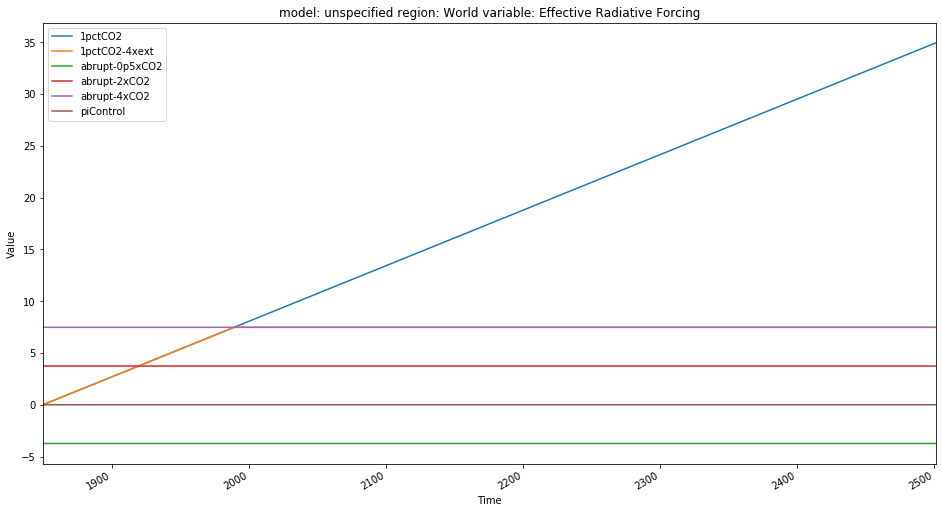

In [11]:
rcmip_effrf.filter(region="World").line_plot(color="scenario", figsize=(16, 9))

## Run

In [12]:
with open("held-two-layer-cfgs.json", "r") as fh:
    held_two_layer_cfgs = json.load(fh)
    
held_two_layer_cfgs[:2]

[{'descr': 'Held two-layer model with state-dependent feedback factor implementation calibrated to the idealised CO2-only experiments for the r1i1p1f1 variant of the BCC-CSM2-MR model',
  'name': 'held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-CALIB',
  'parameter_values': {'C': 93559645.58031182,
   'C_D': 1829168324.6738226,
   'b': -0.0036624992393419643,
   'epsilon': 10.959704053777843,
   'eta': 0.09659984859140298,
   'lambda_0': -1.411520803450022}},
 {'descr': 'Held two-layer model with state-dependent feedback factor implementation calibrated to the idealised CO2-only experiments for the r1i1p1f1 variant of the BCC-ESM1 model',
  'name': 'held-two-layer-uom-CMIP6-BCC-ESM1_r1i1p1f1-CALIB',
  'parameter_values': {'C': 335193706.8727632,
   'C_D': 9911449342.95266,
   'b': 0.07610257917508007,
   'epsilon': 2.7397743695526087,
   'eta': 0.18721947146847945,
   'lambda_0': -1.7929800538967509}}]

In [13]:
def calculate_ecs(lambda_0, b, f2x):
    return (-lambda_0 - ((lambda_0 ** 2 - (4 * f2x * b)) ** 0.5)) / (2 * b)

In [14]:
runners_cfgs = {HeldTwoLayerModel: held_two_layer_cfgs}

results = []
for model, cfgs in tqdm.notebook.tqdm(runners_cfgs.items(), desc="Model"):
    runner = model()
    runner.co2_pi = co2_conc_0
    startyear=1750
    endyear=2500
    scens_to_run = rcmip_effrf.filter(
        mip_era="CMIP6"  # we don't have ERF for CMIP5 stuff...
    )["scenario"].unique()
    for scenario in tqdm.notebook.tqdm(scens_to_run, desc="scenarios", leave=False):
        run_df = rcmip_effrf.filter(scenario=scenario, year=range(startyear, endyear+1))
        for cfg in tqdm.notebook.tqdm(cfgs, desc="configs", leave=False):
            pvs = cfg["parameter_values"]
            res_run = runner.run(run_df, pvs)
            res_run.set_meta(cfg["name"], "climatemodel")
            
            boxes = len([k for k in pvs if k.startswith("c")])
            ecs = calculate_ecs(pvs["lambda_0"], pvs["b"], F2X_CO2)
            res_run.set_meta(ecs, "ECS (K)")
            
            results.append(res_run)
            
results = df_append(results)

/Users/znicholls/Documents/AGCEC/MCastle/openscm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/Users/znicholls/Documents/AGCEC/MCastle/openscm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide
/Users/znicholls/Documents/AGCEC/MCastle/openscm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: overflow encountered in double_scalars
/Users/znicholls/Documents/AGCEC/MCastle/openscm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in double_scalars


/Users/znicholls/Documents/AGCEC/MCastle/openscm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in true_divide


In [15]:
results.filter(scenario="1pctCO2", variable="Surface Temperature*").timeseries()

time                                                                                                              1850-01-01 00:00:00  \
model       scenario region variable            unit ECS (K)  climatemodel                                                              
unspecified 1pctCO2  World  Surface Temperature K    2.631654 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...                  0.0   
                                                     2.312989 held-two-layer-uom-CMIP6-BCC-ESM1_r1i1p1f1-CALIB                    0.0   
                                                     2.550936 held-two-layer-uom-CMIP6-CESM2-WACCM_r1i1p1f1-C...                  0.0   
                                                     3.633154 held-two-layer-uom-CMIP6-CESM2_r1i1p1f1-CALIB                       0.0   
                                                     2.912737 held-two-layer-uom-CMIP6-CNRM-CM6-1_r1i1p1f2-CALIB                  0.0   
                                                     2.286604 held-two-layer-uom-CMIP6-CNRM-ESM2-1_r1i1p1f2-C...                  0.0   
                                                     3.138895 held-two-layer-uom-CMIP6-CanESM5_r1i1p1f1-CALIB                     0.0   
                                                     3.503704 held-two-layer-uom-CMIP6-EC-Earth3-Veg_r1i1p1f1...                  0.0   
                                                     2.503380 held-two-layer-uom-CMIP6-GISS-E2-1-G_r1i1p1f1-C...                  0.0   
                                                     2.477079 held-two-layer-uom-CMIP6-GISS-E2-1-H_r1i1p1f1-C...                  0.0   
                                                     1.902927 held-two-layer-uom-CMIP6-GISS-E2-2-G_r1i1p1f1-C...                  0.0   
                                                     4.569179 held-two-layer-uom-CMIP6-IPSL-CM6A-LR_r1i1p1f1-...                  0.0   
                                                     2.168189 held-two-layer-uom-CMIP6-MPI-ESM1-2-HR_r1i1p1f1...                  0.0   
                                                     4.153464 held-two-layer-uom-CMIP6-NorCPM1_r1i1p1f1-CALIB                     0.0   
                                                     4.106010 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...                  0.0   

time                                                                                                              1850-02-01 00:00:00  \
model       scenario region variable            unit ECS (K)  climatemodel                                                              
unspecified 1pctCO2  World  Surface Temperature K    2.631654 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...                  0.0   
                                                     2.312989 held-two-layer-uom-CMIP6-BCC-ESM1_r1i1p1f1-CALIB                    0.0   
                                                     2.550936 held-two-layer-uom-CMIP6-CESM2-WACCM_r1i1p1f1-C...                  0.0   
                                                     3.633154 held-two-layer-uom-CMIP6-CESM2_r1i1p1f1-CALIB                       0.0   
                                                     2.912737 held-two-layer-uom-CMIP6-CNRM-CM6-1_r1i1p1f2-CALIB                  0.0   
                                                     2.286604 held-two-layer-uom-CMIP6-CNRM-ESM2-1_r1i1p1f2-C...                  0.0   
                                                     3.138895 held-two-layer-uom-CMIP6-CanESM5_r1i1p1f1-CALIB                     0.0   
                                                     3.503704 held-two-layer-uom-CMIP6-EC-Earth3-Veg_r1i1p1f1...                  0.0   
                                                     2.503380 held-two-layer-uom-CMIP6-GISS-E2-1-G_r1i1p1f1-C...                  0.0   
                                                     2.477079 held-two-layer-uom-CMIP6-GISS-E2-1-H_r1i1p1f1-C...                  0.0   
                          

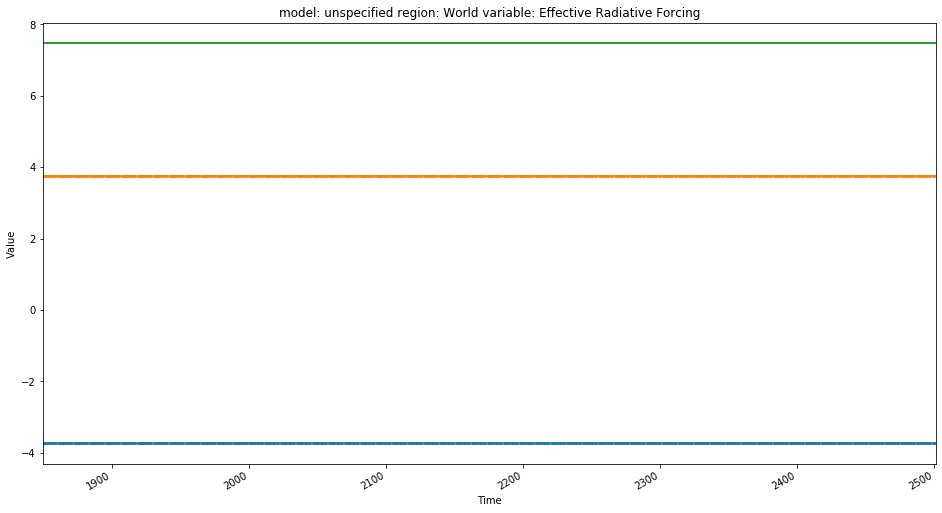

In [16]:
ax = results.filter(scenario="abrupt-*").filter(variable="*Forcing").line_plot(
    figsize=(16, 9), linestyle="climatemodel", color="scenario", legend=False
)

(-4, 15)

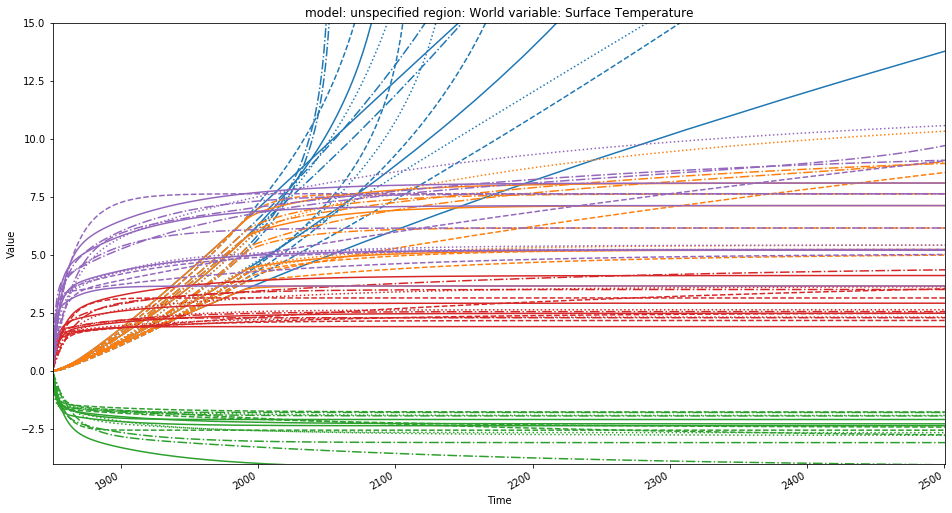

In [17]:
ax = results.filter(scenario=["piControl"], keep=False).filter(variable="Surface Temperature").line_plot(
    figsize=(16, 9), linestyle="climatemodel", color="scenario", legend=False
)
ax.set_ylim([-4, 15])

(-4, 15)

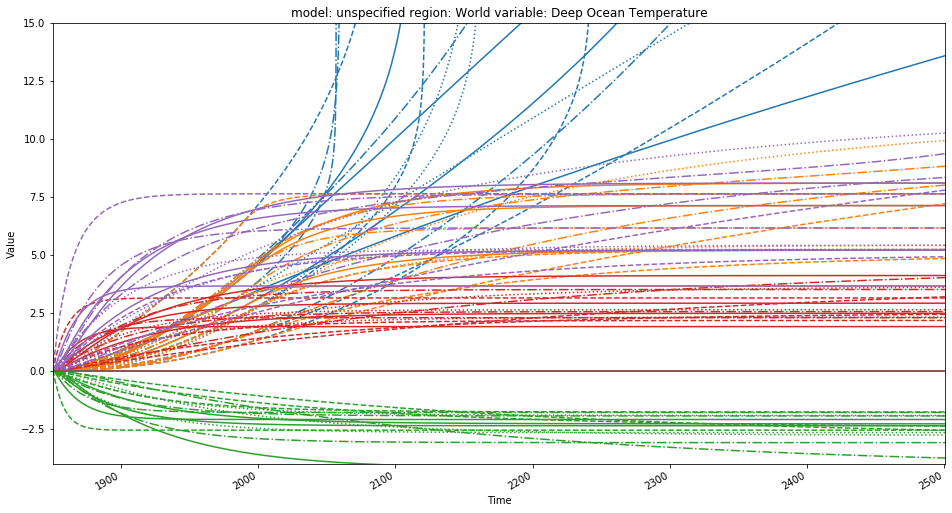

In [18]:
ax = results.filter(variable="Deep Ocean Temperature").line_plot(
    figsize=(16, 9), linestyle="climatemodel", color="scenario", legend=False
)
ax.set_ylim([-4, 15])

In [19]:
results_out = results.time_mean("AC")
results_out.tail()

time                                                                                                                                    1850-07-01 00:00:00  \
model       scenario  region variable                               unit    ECS (K) climatemodel                                                              
unspecified piControl World  Effective Climate Sensitivity          K       4.10601 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...                  NaN   
                             Effective Radiative Forcing            W/m^2   4.10601 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...             0.000000   
                             Net Top of Atmosphere Energy Imbalance W/m^2   4.10601 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...             0.000000   
                             Surface Temperature                    K       4.10601 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...             0.000000   
                             lambda_model                           W/m^2/K 4.10601 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...            -0.897293   

time                                                                                                                                    1851-07-01 00:00:00  \
model       scenario  region variable                               unit    ECS (K) climatemodel                                                              
unspecified piControl World  Effective Climate Sensitivity          K       4.10601 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...                  NaN   
                             Effective Radiative Forcing            W/m^2   4.10601 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...             0.000000   
                             Net Top of Atmosphere Energy Imbalance W/m^2   4.10601 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...             0.000000   
                             Surface Temperature                    K       4.10601 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...             0.000000   
                             lambda_model                           W/m^2/K 4.10601 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...            -0.897293   

time                                                                                                                                    1852-07-01 00:00:00  \
model       scenario  region variable                               unit    ECS (K) climatemodel                                                              
unspecified piControl World  Effective Climate Sensitivity          K       4.10601 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...                  NaN   
                             Effective Radiative Forcing            W/m^2   4.10601 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...             0.000000   
                             Net Top of Atmosphere Energy Imbalance W/m^2   4.10601 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...             0.000000   
                             Surface Temperature                    K       4.10601 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...             0.000000   
                             lambda_model                           W/m^2/K 4.10601 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...            -0.897293   

time                                                                                                                                    1853-07-01 00:00:00  \
model       scenario  region variable                               unit    ECS (K) climatemodel                                                              
unspecified piControl World  Effective Climate Sensitivity          K       4.10601 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...                  NaN   
                             Effective Radiative Forcing            W/m^2   4.10601 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...             0.000000   
                      

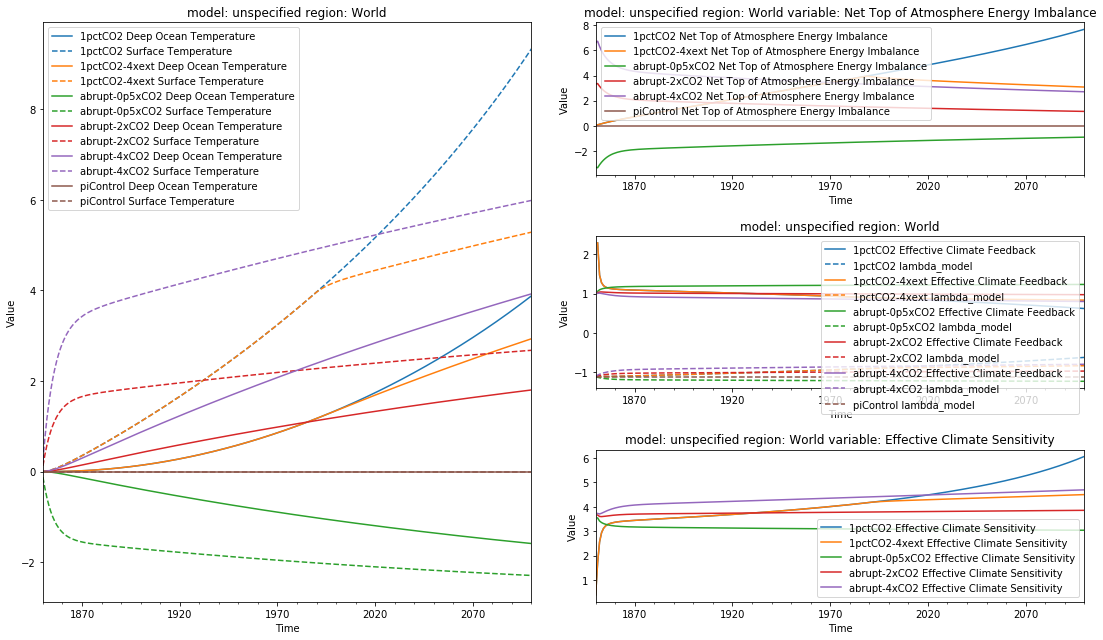

In [20]:
cfg = "BCC-CSM2-MR"
cfg = "UKESM1-0-LL"
cfg = "NorCPM1_r1i1p1f1"
years = range(1850, 2101)
colour_by = "scenario"
linestyle_by = "variable"

pdf = results_out.filter(
    year=years,
    climatemodel="*{}*".format(cfg)
)

fig = plt.figure(figsize=(16, 9))
spec2 = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)
ax1 = fig.add_subplot(spec2[:, 0])
ax2 = fig.add_subplot(spec2[0, 1])
ax3 = fig.add_subplot(spec2[1, 1])
ax4 = fig.add_subplot(spec2[2, 1])

pdf.filter(
    variable=["Surface Temperature", "Deep Ocean Temperature"]
).line_plot(ax=ax1, color=colour_by, linestyle=linestyle_by)
pdf.filter(
    variable=["Net Top of Atmosphere Energy Imbalance"]
).line_plot(ax=ax2, color=colour_by, linestyle=linestyle_by)
pdf.filter(
    variable=["Effective Climate Feedback", "lambda_model"]
).line_plot(ax=ax3, color=colour_by, linestyle=linestyle_by)
pdf.filter(
    variable=["Effective Climate Sensitivity"]
).line_plot(ax=ax4, color=colour_by, linestyle=linestyle_by)
# ax4.set_ylim([-3, 10])

plt.tight_layout()

In [21]:
results_out_with_tcr = []
for cm in results_out["climatemodel"].unique():
    tcr = results_out.filter(
        climatemodel=cm, 
        variable="Surface Temperature", 
        scenario="1pctCO2", 
        year=1920,
    )
    
    tmp = results_out.filter(climatemodel=cm)
    tmp.set_meta(tcr.values.squeeze(), "TCR (K)")
    
    results_out_with_tcr.append(tmp)
    
results_out_with_tcr = df_append(results_out_with_tcr)
results_out_with_tcr.filter(
    scenario="1pctCO2", variable="Surface Temperature"
).timeseries()

time                                                                                                                       1850-07-01 00:00:00  \
model       scenario region variable            unit ECS (K)  TCR (K)  climatemodel                                                              
unspecified 1pctCO2  World  Surface Temperature K    2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...             0.001944   
                                                     2.312989 1.751368 held-two-layer-uom-CMIP6-BCC-ESM1_r1i1p1f1-CALIB               0.000605   
                                                     2.550936 2.017488 held-two-layer-uom-CMIP6-CESM2-WACCM_r1i1p1f1-C...             0.001671   
                                                     3.633154 2.154501 held-two-layer-uom-CMIP6-CESM2_r1i1p1f1-CALIB                  0.000362   
                                                     2.912737 2.322366 held-two-layer-uom-CMIP6-CNRM-CM6-1_r1i1p1f2-CALIB             0.001075   
                                                     2.286604 1.987848 held-two-layer-uom-CMIP6-CNRM-ESM2-1_r1i1p1f2-C...             0.001258   
                                                     3.138895 2.654635 held-two-layer-uom-CMIP6-CanESM5_r1i1p1f1-CALIB                0.000872   
                                                     3.503704 2.498671 held-two-layer-uom-CMIP6-EC-Earth3-Veg_r1i1p1f1...             0.000720   
                                                     2.503380 1.764461 held-two-layer-uom-CMIP6-GISS-E2-1-G_r1i1p1f1-C...             0.001356   
                                                     2.477079 1.898762 held-two-layer-uom-CMIP6-GISS-E2-1-H_r1i1p1f1-C...             0.000763   
                                                     1.902927 1.737073 held-two-layer-uom-CMIP6-GISS-E2-2-G_r1i1p1f1-C...             0.001377   
                                                     4.569179 2.395252 held-two-layer-uom-CMIP6-IPSL-CM6A-LR_r1i1p1f1-...             0.000356   
                                                     2.168189 1.721965 held-two-layer-uom-CMIP6-MPI-ESM1-2-HR_r1i1p1f1...             0.000909   
                                                     4.153464 1.658437 held-two-layer-uom-CMIP6-NorCPM1_r1i1p1f1-CALIB                0.000507   
                                                     4.106010 2.826522 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...             0.000663   

time                                                                                                                       1851-07-01 00:00:00  \
model       scenario region variable            unit ECS (K)  TCR (K)  climatemodel                                                              
unspecified 1pctCO2  World  Surface Temperature K    2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...             0.013104   
                                                     2.312989 1.751368 held-two-layer-uom-CMIP6-BCC-ESM1_r1i1p1f1-CALIB               0.004703   
                                                     2.550936 2.017488 held-two-layer-uom-CMIP6-CESM2-WACCM_r1i1p1f1-C...             0.011727   
                                                     3.633154 2.154501 held-two-layer-uom-CMIP6-CESM2_r1i1p1f1-CALIB                  0.002909   
                                                     2.912737 2.322366 held-two-layer-uom-CMIP6-CNRM-CM6-1_r1i1p1f2-CALIB             0.008136   
                                                     2.286604 1.987848 held-two-layer-uom-CMIP6-CNRM-ESM2-1_r1i1p1f2-C...             0.009152   
                                                     3.138895 2.654635 held-two-layer-uom-CMIP6-CanESM5_r1i1p1f1-CALIB                0.005874   
                                                     3.503704 2.498671 held-two-layer-uom-CMIP6-EC-Earth3-Veg_r1i1p1f1...             0.005636   
                                                     2.50

In [22]:
results_out_with_tcr["variable"].unique()

array(['Deep Ocean Temperature', 'Effective Climate Feedback',
       'Effective Climate Sensitivity', 'Effective Radiative Forcing',
       'Net Top of Atmosphere Energy Imbalance', 'Surface Temperature',
       'lambda_model'], dtype=object)

In [23]:
save_scmdf = results_out_with_tcr.filter(
    variable=["lambda_model", "Deep Ocean Temperature"], keep=False
).timeseries()
save_scmdf.head()

time                                                                                                                                             1850-07-01 00:00:00  \
model       scenario region variable                               unit    ECS (K)  TCR (K)  climatemodel                                                              
unspecified 1pctCO2  World  Effective Climate Feedback             W/m^2/K 2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...                  inf   
                            Effective Climate Sensitivity          K       2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...             1.299710   
                            Effective Radiative Forcing            W/m^2   2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...             0.024491   
                            Net Top of Atmosphere Energy Imbalance W/m^2   2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...             0.019529   
                            Surface Temperature                    K       2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...             0.001944   

time                                                                                                                                             1851-07-01 00:00:00  \
model       scenario region variable                               unit    ECS (K)  TCR (K)  climatemodel                                                              
unspecified 1pctCO2  World  Effective Climate Feedback             W/m^2/K 2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...             0.918921   
                            Effective Climate Sensitivity          K       2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...             4.140601   
                            Effective Radiative Forcing            W/m^2   2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...             0.078180   
                            Net Top of Atmosphere Energy Imbalance W/m^2   2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...             0.066651   
                            Surface Temperature                    K       2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...             0.013104   

time                                                                                                                                             1852-07-01 00:00:00  \
model       scenario region variable                               unit    ECS (K)  TCR (K)  climatemodel                                                              
unspecified 1pctCO2  World  Effective Climate Feedback             W/m^2/K 2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...             0.723799   
                            Effective Climate Sensitivity          K       2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...             5.171639   
                            Effective Radiative Forcing            W/m^2   2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...             0.131924   
                            Net Top of Atmosphere Energy Imbalance W/m^2   2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...             0.110010   
                            Surface Temperature                    K       2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...             0.030433   

time                                                                                                                                             1853-07-01 00:00:00  \
model       scenario region variable                               unit    ECS (K)  TCR (K)  climatemodel                                                              
unspecified 1pctCO2  World  Effective Climate Feedback             W/m^2/K 2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i

Convert TOA energy imbalance to joules per year.

In [24]:
# area of earth ~ 5.1 * 10^14 m2
# seconds per year ~ 365.25 * 24 * 60 * 60 = 31,557,600
# 1 W/m2 = 1 * 5.1 * 10^14 m2 * 3.1557600 * 10 ** 7 = 5.101 * 3.15576 * 10**21
wm2_to_zetajoule = 5.101 * 3.15576
save_scmdf[
    save_scmdf.index.get_level_values("variable") == "Net Top of Atmosphere Energy Imbalance"
] *= wm2_to_zetajoule

save_scmdf = save_scmdf.reset_index()
save_scmdf.loc[
    save_scmdf["variable"] == "Net Top of Atmosphere Energy Imbalance",
    "unit"
] = "ZJ/yr"
save_scmdf.head()

time,model,scenario,region,variable,unit,ECS (K),TCR (K),climatemodel,1850-07-01 00:00:00,1851-07-01 00:00:00,...,2491-07-01 00:00:00,2492-07-01 00:00:00,2493-07-01 00:00:00,2494-07-01 00:00:00,2495-07-01 00:00:00,2496-07-01 00:00:00,2497-07-01 00:00:00,2498-07-01 00:00:00,2499-07-01 00:00:00,2500-07-01 00:00:00
0,unspecified,1pctCO2,World,Effective Climate Feedback,W/m^2/K,2.631654,1.968482,held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-...,inf,0.918921,...,1.452994,1.453187,1.453380,1.453573,1.453765,1.453957,1.454149,1.454341,1.454533,1.454724
1,unspecified,1pctCO2,World,Effective Climate Sensitivity,K,2.631654,1.968482,held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-...,1.299710,4.140601,...,2.573996,2.573654,2.573313,2.572971,2.572630,2.572290,2.571950,2.571611,2.571272,2.570934
2,unspecified,1pctCO2,World,Effective Radiative Forcing,W/m^2,2.631654,1.968482,held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-...,0.024491,0.078180,...,34.439009,34.492753,34.546387,34.600075,34.653764,34.707508,34.761142,34.814831,34.868519,34.922208
3,unspecified,1pctCO2,World,Net Top of Atmosphere Energy Imbalance,ZJ/yr,2.631654,1.968482,held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-...,0.314376,1.072918,...,34.225106,34.220355,34.213912,34.208402,34.202876,34.198136,34.191703,34.186205,34.180689,34.175162
4,unspecified,1pctCO2,World,Surface Temperature,K,2.631654,1.968482,held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-...,0.001944,0.013104,...,22.238845,22.273077,22.307298,22.341507,22.375714,22.409924,22.444123,22.478311,22.512496,22.546676


In [25]:
def rename_vars(inv):
    if inv == "Surface Temperature":
        return "Surface Air Temperature Change"
    
    if inv == "Net Top of Atmosphere Energy Imbalance":
        return "Heat Uptake"
    return inv

save_scmdf["variable"] = save_scmdf["variable"].apply(rename_vars)
save_scmdf = ScmDataFrame(save_scmdf)
save_scmdf = save_scmdf.timeseries()
save_scmdf.columns = save_scmdf.columns.map(lambda x: x.year)
save_scmdf = pyam.IamDataFrame(save_scmdf)
save_scmdf.to_csv("held-two-layer-rcmip-phase-1-results.csv")

In [26]:
save_scmdf["variable"].unique()

array(['Effective Climate Feedback', 'Effective Climate Sensitivity',
       'Effective Radiative Forcing', 'Heat Uptake',
       'Surface Air Temperature Change'], dtype=object)

In [27]:
save_scmdf.head(5)

,model,scenario,region,variable,unit,year,ecs (k),climatemodel,tcr (k),value
0,unspecified,1pctCO2,World,Effective Climate Feedback,W/m^2/K,1850,1.902927,held-two-layer-uom-CMIP6-GISS-E2-2-G_r1i1p1f1-...,1.737073,inf
1,unspecified,1pctCO2,World,Effective Climate Feedback,W/m^2/K,1850,2.168189,held-two-layer-uom-CMIP6-MPI-ESM1-2-HR_r1i1p1f...,1.721965,inf
2,unspecified,1pctCO2,World,Effective Climate Feedback,W/m^2/K,1850,2.286604,held-two-layer-uom-CMIP6-CNRM-ESM2-1_r1i1p1f2-...,1.987848,inf
3,unspecified,1pctCO2,World,Effective Climate Feedback,W/m^2/K,1850,2.312989,held-two-layer-uom-CMIP6-BCC-ESM1_r1i1p1f1-CALIB,1.751368,inf
4,unspecified,1pctCO2,World,Effective Climate Feedback,W/m^2/K,1850,2.477079,held-two-layer-uom-CMIP6-GISS-E2-1-H_r1i1p1f1-...,1.898762,inf


In [28]:
desc = save_scmdf[["climatemodel", "ecs (k)", "tcr (k)"]].drop_duplicates()
desc["name"] = desc["climatemodel"].apply(lambda x: x[:14])
desc["version"] = desc["climatemodel"].apply(lambda x: x[15:18])
desc["config"] = desc["climatemodel"].apply(lambda x: "-".join(x.split("-")[4:]))

desc.to_csv("held-two-layer-rcmip-model-desc.csv")
desc

,climatemodel,ecs (k),tcr (k),name,version,config
0,held-two-layer-uom-CMIP6-GISS-E2-2-G_r1i1p1f1-...,1.902927,1.737073,held-two-layer,uom,CMIP6-GISS-E2-2-G_r1i1p1f1-CALIB
1,held-two-layer-uom-CMIP6-MPI-ESM1-2-HR_r1i1p1f...,2.168189,1.721965,held-two-layer,uom,CMIP6-MPI-ESM1-2-HR_r1i1p1f1-CALIB
2,held-two-layer-uom-CMIP6-CNRM-ESM2-1_r1i1p1f2-...,2.286604,1.987848,held-two-layer,uom,CMIP6-CNRM-ESM2-1_r1i1p1f2-CALIB
3,held-two-layer-uom-CMIP6-BCC-ESM1_r1i1p1f1-CALIB,2.312989,1.751368,held-two-layer,uom,CMIP6-BCC-ESM1_r1i1p1f1-CALIB
4,held-two-layer-uom-CMIP6-GISS-E2-1-H_r1i1p1f1-...,2.477079,1.898762,held-two-layer,uom,CMIP6-GISS-E2-1-H_r1i1p1f1-CALIB
5,held-two-layer-uom-CMIP6-GISS-E2-1-G_r1i1p1f1-...,2.503380,1.764461,held-two-layer,uom,CMIP6-GISS-E2-1-G_r1i1p1f1-CALIB
6,held-two-layer-uom-CMIP6-CESM2-WACCM_r1i1p1f1-...,2.550936,2.017488,held-two-layer,uom,CMIP6-CESM2-WACCM_r1i1p1f1-CALIB
7,held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-...,2.631654,1.968482,held-two-layer,uom,CMIP6-BCC-CSM2-MR_r1i1p1f1-CALIB
8,held-two-layer-uom-CMIP6-CNRM-CM6-1_r1i1p1f2-C...,2.912737,2.322366,held-two-layer,uom,CMIP6-CNRM-CM6-1_r1i1p1f2-CALIB
9,held-two-layer-uom-CMIP6-CanESM5_r1i1p1f1-CALIB,3.138895,2.654635,held-two-layer,uom,CMIP6-CanESM5_r1i1p1f1-CALIB
